In [1]:
!pip install pandas

In [2]:
import polars as pl
import json
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Get datasets
source_folder = "3D-FUTURE-scene"
threedfuture_file_path = "./" + source_folder + '/train/train_set.json'

with open(threedfuture_file_path, 'r') as json_file:
    data = json.load(json_file)

for key in data:
    print(key, len(data[key]))

categories 34
images 14761
annotations 73513


In [4]:
# Create Dataframe tables
# Categories
categories_data = data['categories']
df_categories = pl.DataFrame(categories_data)

df_categories.head()

# Images
images_data = data['images']
df_images = pl.DataFrame(images_data)

df_images.head()

id,width,height,file_name
i64,i64,i64,str
1,1200,1200,"""0000000"""
2,1200,1200,"""0000001"""
3,1200,1200,"""0000002"""
4,1200,1200,"""0000003"""
5,1200,1200,"""0000004"""


In [5]:
# BLIP descriptions
source_folder = "./"
file_path = source_folder + 'blip_anotation_3D_DS.csv'

df = pl.read_csv(file_path)

df.head()

df_joined = df.join(df_categories, left_on="category_id", right_on="id")
df_joined = df_joined.join(df_images.select(pl.exclude(["width", "height"])),      left_on="image_id", right_on="id")

df_joined = df_joined.with_columns(
    df_joined["file_name_right"] + ".jpg",
)

df_joined.head()

,annotation_id,image_id,category_id,area,bbox,model_id,texture_id,fov,style,theme,material,pose,occlusion,width,height,file_name,caption,Room,super-category,category,file_name_right
i64,i64,i64,i64,i64,str,str,str,f64,str,str,str,str,str,i64,i64,i64,str,str,str,str,str
0,1,1,33,13073,"""[526.0, 56.0, …","""da64b6ef-d704-…","""da64b6ef-d704-…",0.958973,"""Modern""",null,null,"""{'translation'…","""NO""",1200,1200,0,"""a bedroom with…","""bedroom""","""Lighting""","""Pendant Lamp""","""0000000.jpg"""
1,2,1,2,8014,"""[1140.0, 795.0…","""4d5ff861-d5ce-…","""4d5ff861-d5ce-…",null,"""Korean""","""Smooth Net""","""Composite Boar…","""{'translation'…","""N/A""",1200,1200,0,"""a bedroom with…","""bedroom""","""Cabinet/Shelf/…","""Nightstand""","""0000000.jpg"""
2,3,1,23,24436,"""[0.0, 603.0, 2…","""a939be24-9c3d-…","""a939be24-9c3d-…",0.958973,"""Light Luxury""","""Gold Foil""","""Composite Boar…","""{'translation'…","""N/A""",1200,1200,0,"""a bedroom with…","""bedroom""","""Table""","""Dressing Table…","""0000000.jpg"""
3,4,1,4,211496,"""[173.0, 287.0,…","""1d9f21cd-359f-…","""1d9f21cd-359f-…",0.958973,"""Korean""","""Smooth Net""","""Composite Boar…","""{'translation'…","""NO""",1200,1200,0,"""a bedroom with…","""bedroom""","""Cabinet/Shelf/…","""Wardrobe""","""0000000.jpg"""
4,5,1,13,235956,"""[414.0, 553.0,…","""433123cb-172e-…","""433123cb-172e-…",0.958973,"""Mediterranean""","""Striped Grid""","""Rough Cloth""","""{'translation'…","""NO""",1200,1200,0,"""a bedroom with…","""bedroom""","""Bed""","""King-size Bed""","""0000000.jpg"""


In [6]:
# Load furniture categories
source_folder = "FINAL"
room_types = [
    "living",
    "bedroom",
    "dining",
]

# Select only relevant room types
df_joined_relevant = df_joined.filter(pl.col("Room").is_in([
    "living room", "bedroom", "dining room"
]))

datasets = {}
dataframes = {}

for room_type in room_types:
    # List all files in the directory
    file_list = os.listdir(f"{source_folder}/{room_type}")

    # Filter files with a ".jpg" extension
    datasets[room_type] = [file for file in file_list if file.lower().endswith(".jpg")]

    dataframes[room_type] = df_joined_relevant.filter(pl.col("file_name_right").is_in(datasets[room_type]))
    


In [7]:
dataframes["dining"]

,annotation_id,image_id,category_id,area,bbox,model_id,texture_id,fov,style,theme,material,pose,occlusion,width,height,file_name,caption,Room,super-category,category,file_name_right
i64,i64,i64,i64,i64,str,str,str,f64,str,str,str,str,str,i64,i64,i64,str,str,str,str,str
39,40,10,33,12388,"""[477.0, 122.0,…","""d269fca6-d843-…","""d269fca6-d843-…",1.150612,"""Modern""",null,null,"""{'translation'…","""Slight""",1200,1200,9,"""a dining room …","""dining room""","""Lighting""","""Pendant Lamp""","""0000009.jpg"""
40,41,10,22,18963,"""[597.0, 773.0,…","""24ce56dd-6d29-…","""24ce56dd-6d29-…",1.150612,null,null,null,"""{'translation'…","""NO""",1200,1200,9,"""a dining room …","""dining room""","""Chair""","""Barstool""","""0000009.jpg"""
41,42,10,22,5657,"""[719.0, 712.0,…","""24ce56dd-6d29-…","""24ce56dd-6d29-…",1.150612,null,null,null,"""{'translation'…","""Heavy""",1200,1200,9,"""a dining room …","""dining room""","""Chair""","""Barstool""","""0000009.jpg"""
42,43,10,24,35607,"""[200.0, 745.0,…","""5fc8fb35-60d0-…","""5fc8fb35-60d0-…",1.150612,"""Modern""","""Smooth Net""","""Composite Boar…","""{'translation'…","""Standard""",1200,1200,9,"""a dining room …","""dining room""","""Table""","""Dining Table""","""0000009.jpg"""
43,44,10,7,72976,"""[868.0, 729.0,…","""fe8c3645-20c5-…","""fe8c3645-20c5-…",1.150612,"""Modern""","""Lines""","""Composite Boar…","""{'translation'…","""N/A""",1200,1200,9,"""a dining room …","""dining room""","""Cabinet/Shelf/…","""Sideboard / Si…","""0000009.jpg"""
44,45,10,22,5980,"""[366.0, 723.0,…","""24ce56dd-6d29-…","""24ce56dd-6d29-…",1.150612,null,null,null,"""{'translation'…","""Heavy""",1200,1200,9,"""a dining room …","""dining room""","""Chair""","""Barstool""","""0000009.jpg"""
45,46,10,22,27865,"""[23.0, 797.0, …","""24ce56dd-6d29-…","""24ce56dd-6d29-…",1.150612,null,null,null,"""{'translation'…","""NO""",1200,1200,9,"""a dining room …","""dining room""","""Chair""","""Barstool""","""0000009.jpg"""
121,122,31,18,18248,"""[321.0, 792.0,…","""12682f54-bdc8-…","""12682f54-bdc8-…",null,"""Korean""","""Wrought Iron""","""Metal""","""{'translation'…","""N/A""",1200,1200,30,"""a dining room …","""dining room""","""Chair""","""Dining Chair""","""0000030.jpg"""
122,123,31,7,93750,"""[151.0, 714.0,…","""fcd82692-9c3b-…","""fcd82692-9c3b-…",0.620767,"""Modern""","""Lines""","""Others""","""{'translation'…","""Heavy""",1200,1200,30,"""a dining room …","""dining room""","""Cabinet/Shelf/…","""Sideboard / Si…","""0000030.jpg"""


In [8]:
def show_stats(df):
    # Pivot the data to create a heatmap
    heatmap_data = df.to_pandas()
    # Create a crosstab between "style" and "category" counts
    crosstab = pd.crosstab(df['category'], df['style'])

    # Create a heatmap of the crosstab
    plt.figure(figsize=(12, 10))
    plt.imshow(crosstab, cmap='Blues', aspect='auto')

    # Add count labels to the heatmap cells
    for i in range(len(crosstab.index)):
        for j in range(len(crosstab.columns)):
            count = crosstab.iloc[i, j]
            if crosstab.iloc[i, j]:
                plt.text(j, i, count, ha='center', va='center', color='w' if count > 20 else 'gray')

    # Set axis labels and ticks
    plt.xticks(range(len(crosstab.columns)), crosstab.columns, rotation=90)
    plt.yticks(range(len(crosstab.index)), crosstab.index)

    # Set labels for the color bar
    cbar = plt.colorbar()
    cbar.set_label('Counts')

    plt.title('Style vs. Category Counts Heatmap')
    plt.xlabel('Style')
    plt.ylabel('Category')

    plt.show()

Room: living


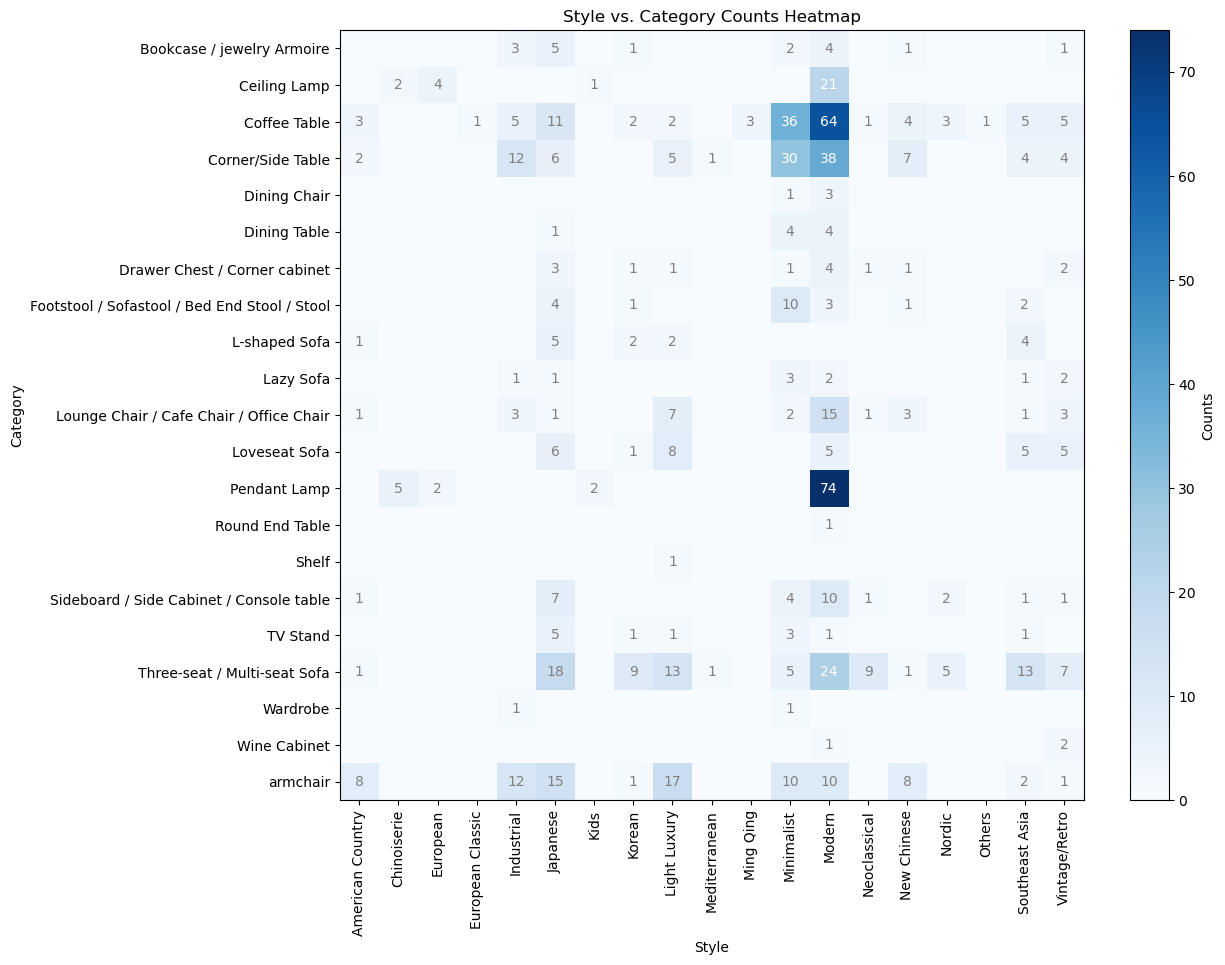

Room: bedroom


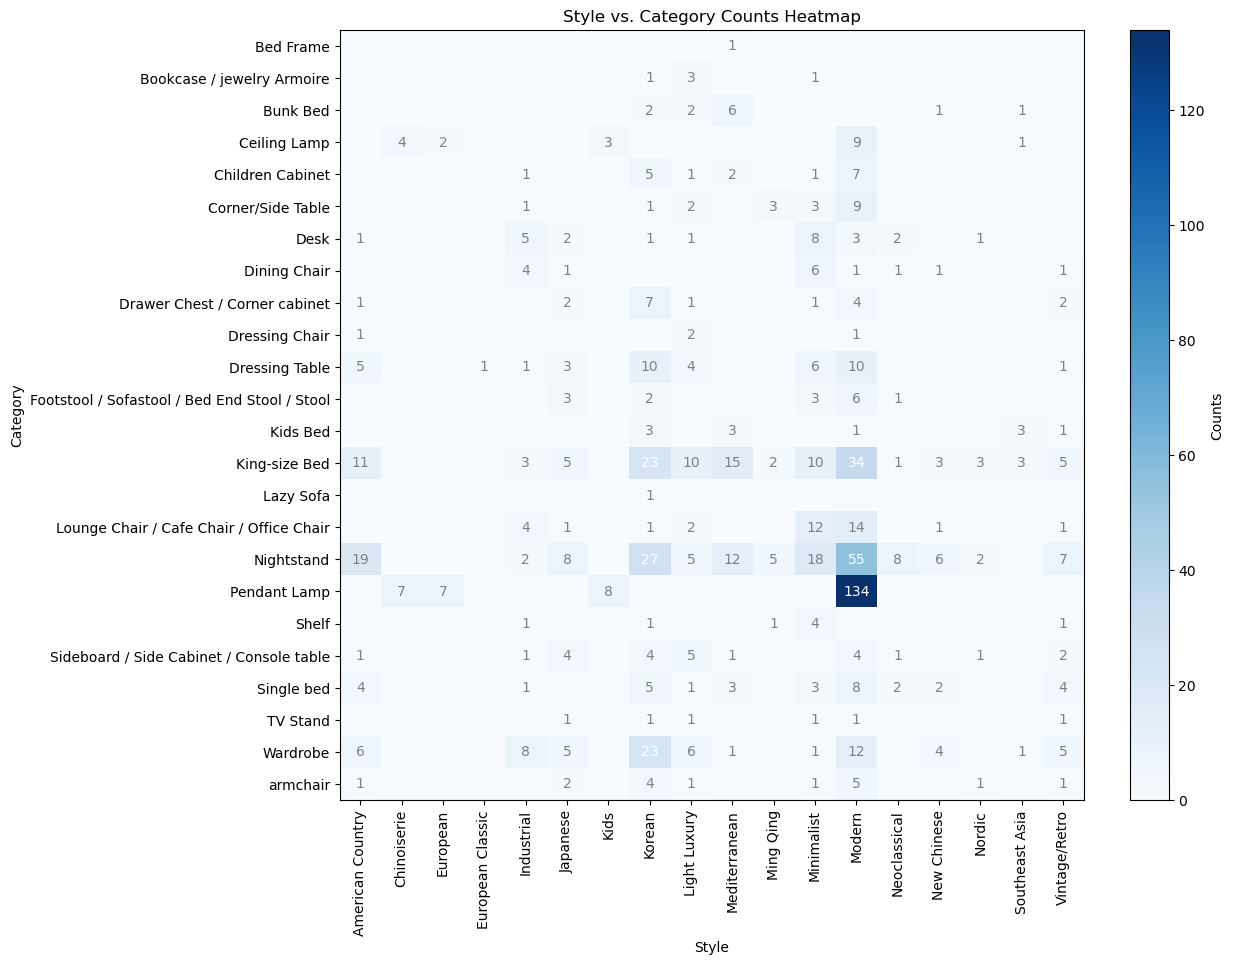

Room: dining


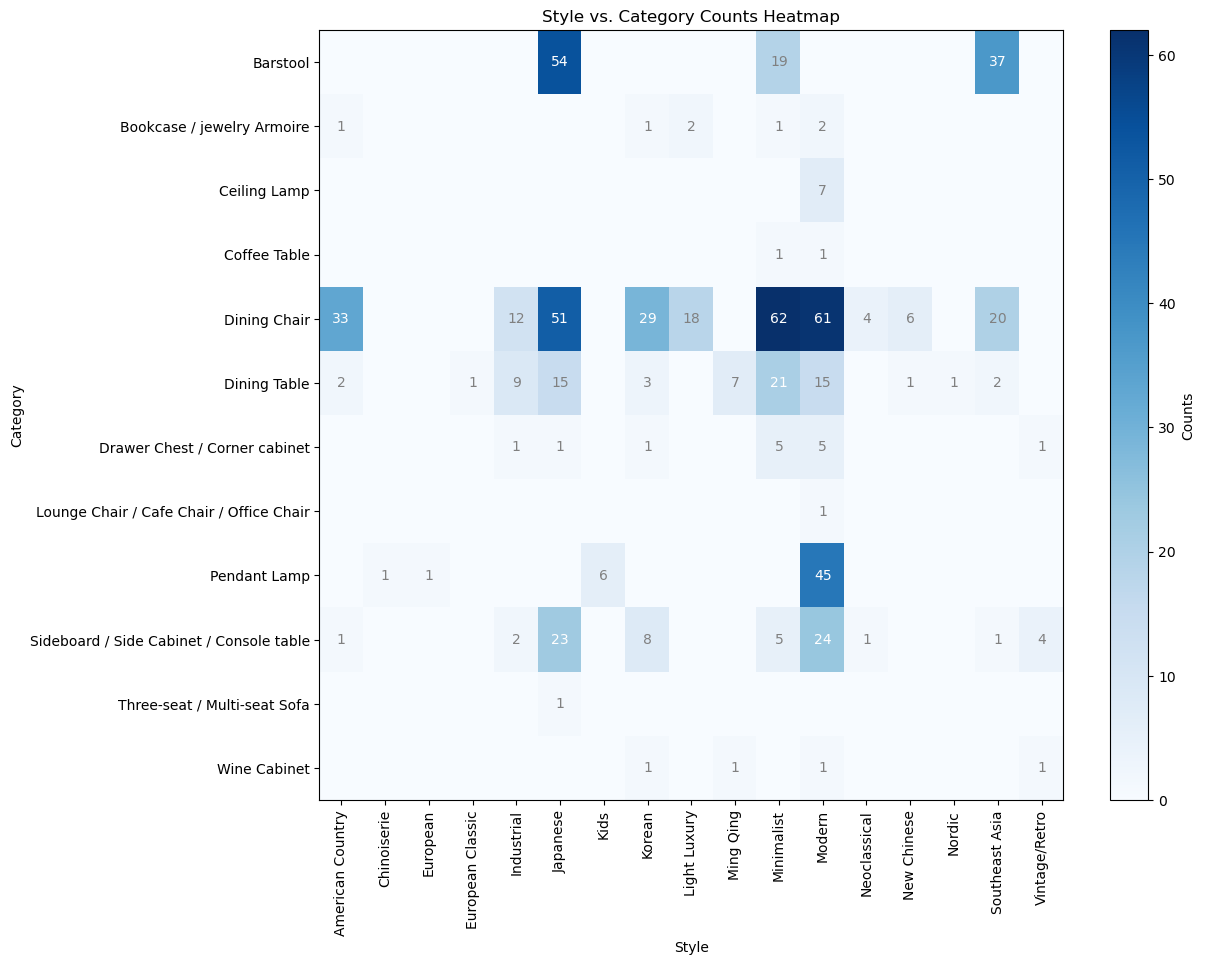

In [9]:
for room_type in room_types:
    print(f"Room: {room_type}")
    show_stats(dataframes[room_type])

In [40]:
# List out all unique object styles
objects = {}

for room_type in room_types:
    df = dataframes[room_type]
    df_uq = df.select(['style','theme','material', 'category']).unique()
    df_uq = df.with_columns(
        pl.when(pl.col(pl.Utf8).str.contains(r"(?i)others"))
            .then(None)
            .otherwise(pl.col(pl.Utf8)) # keep original value
            .keep_name()
    )
    df_desc = df_uq.with_columns(
         pl.concat_str(
            [
                pl.col("style").str.strip_chars().fill_null(""),
                pl.col("theme").str.strip_chars().fill_null(""),
                pl.col("material").str.strip_chars().fill_null(""),
                pl.col("category").str.strip_chars().fill_null(""),
            ],
            separator=" ",
        ).str.strip_chars().alias("description")
    )
    objects[room_type] = df_desc["description"].to_list()

In [41]:
objects

{'living': ['Japanese Lines Cloth Loveseat Sofa',
  'Korean Wooden Vertical Texture Composite Board TV Stand',
  'Modern Smooth Net  Corner/Side Table',
  'Korean Smooth Net Rough Cloth L-shaped Sofa',
  'Modern   Pendant Lamp',
  'Minimalist Smooth Net  Coffee Table',
  'Light Luxury Smooth Net Rough Cloth armchair',
  'Modern   Pendant Lamp',
  'L-shaped Sofa',
  'Minimalist Gold Foil Marble Coffee Table',
  'Modern   Pendant Lamp',
  'Three-seat / Multi-seat Sofa',
  'Modern Smooth Net Marble Coffee Table',
  'Industrial Smooth Net Leather armchair',
  'Modern Smooth Net Composite Board Bookcase / jewelry Armoire',
  'Southeast Asia Smooth Net Wood Sideboard / Side Cabinet / Console table',
  'Modern   Pendant Lamp',
  'Minimalist Smooth Net Rough Cloth armchair',
  'Minimalist Texture Mark Wood Footstool / Sofastool / Bed End Stool / Stool',
  'Vintage/Retro Smooth Net Rough Cloth Three-seat / Multi-seat Sofa',
  'New Chinese Gold Foil Metal Bookcase / jewelry Armoire',
  'Modern S